In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

In [63]:
credit = pd.read_csv('C:/Users/Administrator/Desktop/Datasets/credit-default.csv')
credit_dummies = pd.get_dummies(credit)
train, test = train_test_split(credit_dummies, test_size = 0.3, random_state = 100)
train_x = train.drop('default', axis = 1)
test_x = test.drop('default', axis = 1)
train_y = train['default']
test_y = test['default']

In [64]:
test_x.shape

(300, 61)

In [65]:
from sklearn.metrics import accuracy_score, classification_report
test_pred = np.ones(test_x.shape[0])
accuracy_score(test_y, test_pred) 

0.73

In [73]:
confusion_matrix(test_y, test_pred, labels=[1,2]).ravel()

array([200,  19,  53,  28], dtype=int64)

In [74]:
# 1 = Negative, 2 = Positive

df_pred = pd.DataFrame({'actual' : test_y,
                       'predicted' : test_pred})
## True Positive
tp = df_pred[(df_pred['predicted'] == 2) & (df_pred['actual']==2)].shape[0]
## True Negative
tn = df_pred[(df_pred['predicted'] == 1) & (df_pred['actual']==1)].shape[0]
## False Positive
fp = df_pred[(df_pred['predicted'] == 1) & (df_pred['actual']==2)].shape[0]
## False Negative
fn = df_pred[(df_pred['predicted'] == 2) & (df_pred['actual']==1)].shape[0]

print('True Positive: %d' % tp)
print('True Negative: %d' % tn)
print('False Positive %d' % fp)
print('False Negative %d' % fn)

True Positive: 28
True Negative: 200
False Positive 53
False Negative 19


In [61]:
sensitivity = tp / (tp+fn) * 100
sensitivity

59.57446808510638

In [62]:
specificity = tn / (fp+tn) * 100
specificity

79.05138339920948

# Parameter Tuning
    - tuning the output

In [69]:
model = RandomForestClassifier(random_state=100)
model.fit(train_x, train_y)
test_pred = model.predict(test_x)
accuracy_score(test_y, test_pred)
confusion_matrix(test_y, test_pred, labels=[1,2])
test_pred[:5]

array([1, 2, 1, 2, 1], dtype=int64)

In [68]:
probs = pd.DataFrame(model.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
probs.head()

,Neg_1,Pos_2
0,0.5,0.5
1,0.1,0.9
2,0.7,0.3
3,0.3,0.7
4,0.6,0.4


In [90]:
cut_off = 0.4
test_pred2 = probs['Pos_2'].apply(lambda v: 2 if v > cut_off else 1)
tn,fp,fn,tp = confusion_matrix(test_y, test_pred2, labels=[1,2]).ravel()
sensitivity = tp / (tp+fn) * 100
specificity = tn / (fp+tn) * 100

print('Cut-off %.2f, Sensitivity %.1f, Specificity %.1f' % (cut_off, sensitivity, specificity))

Cut-off 0.40, Sensitivity 48.1, Specificity 81.7


In [72]:
test_pred2.head()

0    2
1    2
2    1
3    2
4    2
Name: Pos_2, dtype: int64

In [79]:
cut_offs = []
tpr = []  # truepositive rate/ sensitivity
fpr = []  # falsepositive rate/ specificity
for cut_off in np.linspace(0,1, 11):
    #print(cut_off)
    test_pred2 = probs['Pos_2'].apply(lambda v: 2 if v > cut_off else 1)
    tn,fp,fn,tp = confusion_matrix(test_y, test_pred2, labels=[1,2]).ravel()
    sensitivity = tp / (tp+fn) * 100
    specificity = tn / (fp+tn) * 100
    cut_offs.append(cut_off)
    tpr.append(sensitivity)
    fpr.append(1 - specificity)
print(cut_offs)
print('-------')
print(tpr)
print('---------')
print(fpr)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
-------
[95.06172839506173, 90.12345679012346, 81.48148148148148, 65.4320987654321, 48.148148148148145, 34.5679012345679, 18.51851851851852, 4.938271604938271, 2.4691358024691357, 0.0, 0.0]
---------
[-12.24200913242009, -32.789954337899545, -48.31506849315068, -69.31963470319634, -80.7351598173516, -90.32420091324201, -94.8904109589041, -97.17351598173516, -97.63013698630137, -99.0, -99.0]


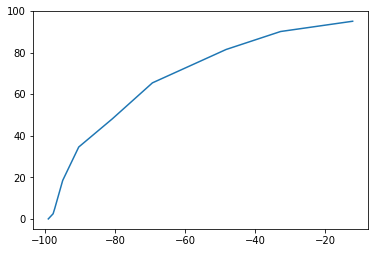

In [82]:
import matplotlib.pyplot as plt
plt.plot(fpr,tpr)

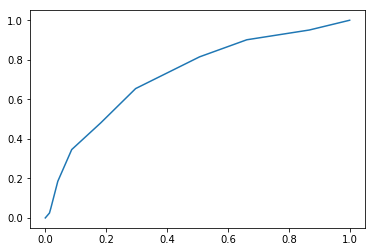

In [85]:
from sklearn.metrics import roc_curve
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 2)
plt.plot(fpr,tpr)

In [91]:
df_roc = pd.DataFrame({'cut-off': cutoffs,
                       'fpr':fpr, 'tpr': tpr, 'specificity': 1 - fpr})
df_roc['youden_index'] = df_roc['tpr'] + df_roc['specificity'] - 1
df_roc.sort_values(by='youden_index', ascending = False).head(1)

,cut-off,fpr,tpr,specificity,youden_index
6,0.4,0.296804,0.654321,0.703196,0.357517


In [96]:
test_pred_new = probs['Pos_2'].apply(lambda v: 2 if v> 0.4 else 1)
test_pred_new.head()

0    2
1    2
2    1
3    2
4    1
Name: Pos_2, dtype: int64

# Credit Dataset

Random Forest AUC : 0.75
Decision Tree AUC : 0.65
AdaBoost AUC : 0.74


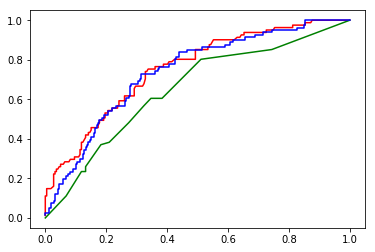

In [112]:
from sklearn.metrics import auc

#Random Forest

model1 = RandomForestClassifier(random_state=100, n_estimators=1000)
model1.fit(train_x, train_y)
test_pred = model1.predict(test_x)
probs = pd.DataFrame(model1.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 2)
plt.plot(fpr,tpr, color='red')
auc_rf = auc(fpr, tpr)
print('Random Forest AUC : %.2f' % auc_rf)

#Decision Tree

model2 = DecisionTreeClassifier(max_depth = 7, random_state=100)
model2.fit(train_x, train_y)
test_pred = model2.predict(test_x)
probs = pd.DataFrame(model2.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 2)
plt.plot(fpr,tpr, color='green')
auc_dt = auc(fpr, tpr)
print('Decision Tree AUC : %.2f' % auc_dt)

#AdaBoost

model3 = AdaBoostClassifier(random_state=100)
model3.fit(train_x, train_y)
test_pred = model3.predict(test_x)
probs = pd.DataFrame(model3.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 2)
plt.plot(fpr,tpr, color='blue')
auc_ab = auc(fpr, tpr)
print('AdaBoost AUC : %.2f' % auc_ab)

# HR Dataset

In [115]:
hr_url = 'https://raw.githubusercontent.com/skathirmani/datasets/master/HR%20Analytics.csv'
hr = pd.read_csv(hr_url)

hr_dummies = pd.get_dummies(hr)

train, test = train_test_split(hr_dummies, test_size = 0.3, random_state = 100)

train_y = train['Attrition']
test_y = test['Attrition']
train_x = train.drop('Attrition', axis = 1)
test_x = test.drop('Attrition', axis = 1)

Random Forest AUC : 0.76
Decision Tree AUC : 0.60
AdaBoost AUC : 0.78


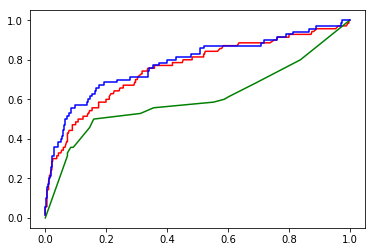

In [125]:
from sklearn.metrics import auc

#Random Forest

model1 = RandomForestClassifier(random_state=100, n_estimators=1000)
model1.fit(train_x, train_y)
test_pred = model1.predict(test_x)
probs = pd.DataFrame(model1.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 1)
plt.plot(fpr,tpr, color='red')
auc_rf = auc(fpr, tpr)
print('Random Forest AUC : %.2f' % auc_rf)

#Decision Tree

model2 = DecisionTreeClassifier(max_depth = 7, random_state=100)
model2.fit(train_x, train_y)
test_pred = model2.predict(test_x)
probs = pd.DataFrame(model2.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 1)
plt.plot(fpr,tpr, color='green')
auc_dt = auc(fpr, tpr)
print('Decision Tree AUC : %.2f' % auc_dt)

#AdaBoost

model3 = AdaBoostClassifier(random_state=100)
model3.fit(train_x, train_y)
test_pred = model3.predict(test_x)
probs = pd.DataFrame(model3.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 1)
plt.plot(fpr,tpr, color='blue')
auc_ab = auc(fpr, tpr)
print('AdaBoost AUC : %.2f' % auc_ab)

# Bank Dataset

In [128]:
bank = pd.read_csv('C:/Users/Administrator/Desktop/Datasets/bank.csv', sep= ';')
bank_new = bank.drop('y', axis = 1)
bank_dummies = pd.get_dummies(bank_new)
bank_dummies['y'] = bank['y']
train, test = train_test_split(bank_dummies, test_size = 0.3, random_state = 100)
train_y = train['y']
test_y = test['y']
train_x = train.drop('y', axis = 1)
test_x = test.drop('y', axis = 1)

Random Forest AUC : 0.93
Decision Tree AUC : 0.86
AdaBoost AUC : 0.91


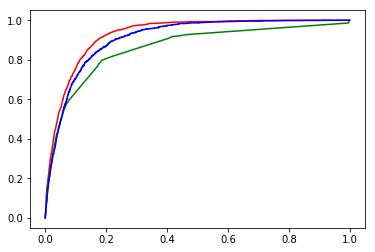

In [132]:
from sklearn.metrics import auc

#Random Forest

model1 = RandomForestClassifier(random_state=100, n_estimators=1000)
model1.fit(train_x, train_y)
test_pred = model1.predict(test_x)
probs = pd.DataFrame(model1.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 'yes')
plt.plot(fpr,tpr, color='red')
auc_rf = auc(fpr, tpr)
print('Random Forest AUC : %.2f' % auc_rf)

#Decision Tree

model2 = DecisionTreeClassifier(max_depth = 7, random_state=100)
model2.fit(train_x, train_y)
test_pred = model2.predict(test_x)
probs = pd.DataFrame(model2.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 'yes')
plt.plot(fpr,tpr, color='green')
auc_dt = auc(fpr, tpr)
print('Decision Tree AUC : %.2f' % auc_dt)

#AdaBoost

model3 = AdaBoostClassifier(random_state=100)
model3.fit(train_x, train_y)
test_pred = model3.predict(test_x)
probs = pd.DataFrame(model3.predict_proba(test_x), columns=['Neg_1', 'Pos_2'])
fpr, tpr, cutoffs = roc_curve(test_y, probs['Pos_2'], pos_label = 'yes')
plt.plot(fpr,tpr, color='blue')
auc_ab = auc(fpr, tpr)
print('AdaBoost AUC : %.2f' % auc_ab)